In [12]:
import networkx as nx
import pandas as pd
from functools import reduce
import numpy as np
from enum import Enum

edge_df = pd.read_csv('../data/filtered_backlinks.csv')
edge_df = edge_df.groupby(['domain_from', 'domain_to'])
edge_df = edge_df.max()
edge_df.reset_index(inplace=True)
edge_df['log_links'] = np.log(edge_df['links'])

node_mapping = {k: v for v, k in enumerate(set(list(edge_df.domain_from.unique()) + list(edge_df.domain_to.unique())))}

edge_df['domain_from_idx'] = edge_df.domain_from.map(node_mapping)
edge_df['domain_to_idx'] = edge_df.domain_to.map(node_mapping)

G = nx.from_pandas_edgelist(edge_df, source='domain_from_idx', target='domain_to_idx', edge_attr=['links', 'unique_pages'], create_using=nx.DiGraph())
schemes = pd.read_csv('schemes.csv')['url'].to_list()
media_df = pd.read_csv('../data/filtered_attrs.csv')

In [13]:
from sklearn import neighbors

centralities = False
if centralities:
    def alpha(n):
        return 1/np.max([np.real(x) for x in nx.adjacency_spectrum(n, weight='log_links')])
    print('PG')
    pagerank_centrality = nx.pagerank(G, weight='log_links')
    # print('KT')
    # katz_centrality = nx.katz_centrality(G, weight='log_links', alpha=alpha(G))
    print('CL')
    closeness_centrality = nx.closeness_centrality(G, distance=1, wf_improved=False)
    print('HM')
    harmonic_centrality = nx.harmonic_centrality(G, distance=1)
    print('BT')
    betweeness_centrality = nx.betweenness_centrality(G, weight='log_links')
    print('DG')
    degree_centrality = nx.degree_centrality(G)#,  weight='log_links')
    degree_centrality = nx.degree_centrality(G)#,  weight='log_links')

def isBlogping(url):
    blogs = ['blogspot', 'e-monsite', 'wordpress', 'blogger']
    return any([blog in url for blog in blogs])

target_urls = list(edge_df.domain_to.unique())
blogping_data = []
inv_node_mapping = {v: k for k, v in node_mapping.items()}

link_scheme_pp = {1:0, 3:0, 4:0, 5:0, 6:0}
normal_backlinker_pp = {1:0, 3:0, 4:0, 5:0, 6:0}

backlink_dists = {}

for news_url in target_urls:
    current_node = node_mapping[news_url]
    preds = G.predecessors(current_node)
    count = 0
    bl_total = 0
    page_total = 0
    try:
        label = media_df[media_df['url'] == news_url]['label'].values[0]
    except:
        print(news_url)
        
    for neighbor in list(preds):
        neighbor_url = inv_node_mapping[neighbor]
        edge_data = G.get_edge_data(neighbor, current_node)
        if isBlogping(neighbor_url):
            count += 1
            bl_total += edge_data['links']
            page_total += edge_data['unique_pages']
        try:
            num_outlinks = 0
            if not neighbor_url in backlink_dists:
                total_links_observed = 0
                for successor in G.successors(neighbor):
                    total_links_observed += G.get_edge_data(neighbor, successor)['links']
                    num_outlinks += 1

                backlink_dists[neighbor_url] = {1:0, 3:0, 4:0, 5:0, 6:0, 7:total_links_observed}
            
            total_links_observed = backlink_dists[neighbor_url][7]
            backlink_dists[neighbor_url][label] += edge_data['links']/total_links_observed

            if total_links_observed > 50000 and num_outlinks > 3:
                if neighbor_url in schemes:
                    link_scheme_pp[label] += edge_data['links']
                elif not isBlogping(neighbor_url):
                    normal_backlinker_pp[label] += edge_data['links']
        except Exception as e:
            print(neighbor_url, e)

    if centralities:
        blogping_data.append({
            'url': news_url,
            'blogspot_backlinks': bl_total,
            'blogspot_refpages': page_total,
            'blogspot_count': count,
            'pagerank_centrality': pagerank_centrality[current_node],
            # 'katz_centrality': katz_centrality[current_node],
            'closeness_centrality': closeness_centrality[current_node],
            'harmonic_centrality': harmonic_centrality[current_node],
            'betweeness_centrality': betweeness_centrality[current_node],
            'degree_centrality': degree_centrality[current_node],
        })
    else:
        blogping_data.append({
            'url': news_url,
            'blogspot_backlinks': bl_total,
            'blogspot_refpages': page_total,
            'blogspot_count': count,
        })

blogping_df = pd.DataFrame(blogping_data)

stillnessinthestorm.com
freerepublic.com
democraticunderground.com
attitude.co.uk
thepoliticalinsider.com
truthuncensored.net
independentminute.com
nation.com.pk


In [14]:
normal_backlinker_pp[3] = normal_backlinker_pp[3] + normal_backlinker_pp[1]
link_scheme_pp[3] = link_scheme_pp[3] + link_scheme_pp[1]
normal_backlinker_pp[5] = normal_backlinker_pp[5] + normal_backlinker_pp[6]
link_scheme_pp[5] = link_scheme_pp[5] + link_scheme_pp[6]
del normal_backlinker_pp[6]
del normal_backlinker_pp[1]
del link_scheme_pp[1]
del link_scheme_pp[6]


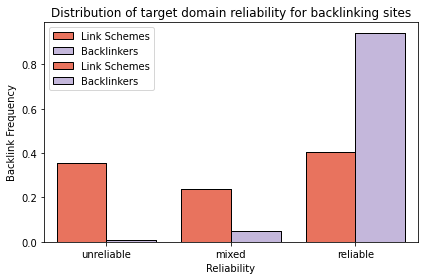

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


total_ls = sum(link_scheme_pp.values())
total_nb = sum(normal_backlinker_pp.values())
ls_proportions = [count / total_ls for count in link_scheme_pp.values()]
nb_proportions = [count / total_nb for count in normal_backlinker_pp.values()]
data = {
    'Reliability': ['unreliable', 'mixed', 'reliable'],
    'Link Schemes': ls_proportions,
    'Backlinkers': nb_proportions
}
df = pd.DataFrame(data)
df_melted = df.melt(id_vars='Reliability', var_name='Type', value_name='Frequency')

sns.barplot(data=df_melted, x='Reliability', y='Frequency', hue='Type', palette=['tomato', '#C3B1E1'], linewidth=1, edgecolor='black')
sns.barplot(data=df_melted, x='Reliability', y='Frequency', hue='Type', palette=['tomato', '#C3B1E1'], linewidth=1, edgecolor='black')
plt.xlabel('Reliability')
plt.ylabel('Backlink Frequency')
plt.title('Distribution of target domain reliability for backlinking sites')
plt.legend(title=None)
plt.tight_layout()
plt.savefig('../results/fig/link_scheme_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
labelled_blogping = pd.merge(blogping_df, media_df, how='inner', on='url')
labelled_blogping['blogspot_link_ratio'] = labelled_blogping['blogspot_backlinks']/labelled_blogping['backlinks']
labelled_blogping['blogspot_page_ratio'] = labelled_blogping['blogspot_refpages']/labelled_blogping['refpages']

/home/peter/dev/envs/env_seo/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


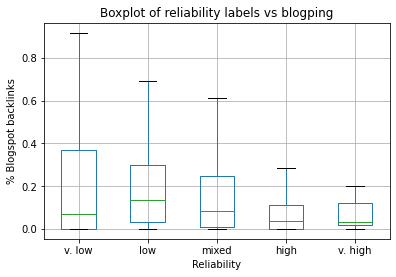

In [17]:
labelled_blogping['log_blogspot_link_ratio'] = np.log10(labelled_blogping['blogspot_count'])

from matplotlib import pyplot as plt
fig, ax = plt.subplots()

labelled_blogping.boxplot(column='blogspot_link_ratio', by='label', ax=ax, showfliers=False)
fig.suptitle('')
ax.set_title('Boxplot of reliability labels vs blogping')
ax.set_xlabel('Reliability')
ax.set_ylabel('% Blogspot backlinks')
ax.set_xticklabels(['v. low', 'low', 'mixed', 'high', 'v. high'])
plt.savefig('../results/fig/blogping.png', dpi=300, bbox_inches='tight')

[Text(1, 0, 'v. low'),
 Text(2, 0, 'low'),
 Text(3, 0, 'mixed'),
 Text(4, 0, 'high'),
 Text(5, 0, 'v. high')]

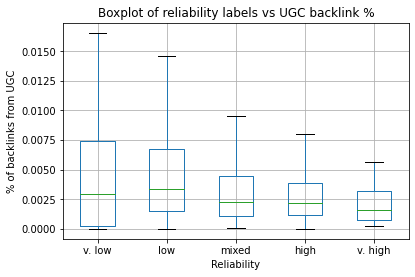

In [18]:
fig, ax = plt.subplots()
labelled_blogping['proportion_ugc'] = labelled_blogping['ugc']/labelled_blogping['backlinks']

labelled_blogping.boxplot(column='proportion_ugc', by='label', ax=ax, showfliers=False)
fig.suptitle('')
ax.set_title('Boxplot of reliability labels vs UGC backlink %')
ax.set_xlabel('Reliability')
ax.set_ylabel('% of backlinks from UGC')
ax.set_xticklabels(['v. low', 'low', 'mixed', 'high', 'v. high'])

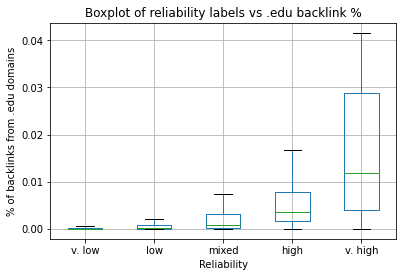

In [19]:
fig, ax = plt.subplots()
labelled_blogping['proportion_edu'] = labelled_blogping['edu']/labelled_blogping['backlinks']

labelled_blogping.boxplot(column='proportion_edu', by='label', ax=ax, showfliers=False)
fig.suptitle('')
ax.set_title('Boxplot of reliability labels vs .edu backlink %')
ax.set_xlabel('Reliability')
ax.set_ylabel('% of backlinks from .edu domains')
ax.set_xticklabels(['v. low', 'low', 'mixed', 'high', 'v. high'])
plt.savefig('../results/fig/edu.png', dpi=300, bbox_inches='tight')

In [20]:
labelled_blogping.groupby('label').describe()['blogspot_count']

/home/peter/dev/envs/env_seo/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/peter/dev/envs/env_seo/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1,166.0,2.493976,2.463668,0.0,0.0,2.0,4.00,10.0
3,481.0,3.457380,2.439850,0.0,1.0,3.0,5.00,10.0
4,524.0,3.089695,2.595328,0.0,1.0,3.0,5.00,10.0
5,2014.0,2.303376,2.248324,0.0,0.0,2.0,4.00,10.0
6,18.0,2.388889,1.914001,0.0,1.0,2.0,3.75,7.0


In [21]:
bias_df = pd.read_csv ('../data/bias_labels.csv')
bias_df.rename(columns={'domain':'url', 'label':'bias'}, inplace=True)
bias_df['url'].str.strip()

label_schemes = {
    'reliability': {6:1,5:1,4:0,3:0,2:0,1:0}, # reliability labels
    'abs_bias': {-2:1,-1:0,0:0,1:0,2:1}, # absolute bias: extreme vs centrist
    'rel_bias': {-2:0,-1:0,0:-1,1:1,2:1}, # relative bias: left vs right
} 

rel_bias_df = bias_df.copy()
rel_bias_df['rel_bias'] = rel_bias_df.bias.astype(int).replace(label_schemes['rel_bias'])
bias_df['abs_bias'] = bias_df.bias.astype(int).replace(label_schemes['abs_bias'])
rel_bias_df = rel_bias_df[rel_bias_df.rel_bias != -1]
rel_bias_df.groupby('rel_bias').describe()

bias                                             
           count      mean       std  min  25%  50%  75%  max
rel_bias                                                     
0         1013.0 -1.301086  0.458957 -2.0 -2.0 -1.0 -1.0 -1.0
1          805.0  1.494410  0.500280  1.0  1.0  1.0  2.0  2.0

In [25]:
labelled_blogping_reliability = labelled_blogping.copy()
labelled_blogping_reliability['bias'] = bias_df['bias']
labelled_blogping_reliability['reliability'] = labelled_blogping_reliability.label.astype(int).replace(label_schemes['reliability'])
labelled_blogping_reliability.corr()['reliability']

blogspot_backlinks        -0.010903
blogspot_refpages         -0.031341
blogspot_count            -0.171795
label                      0.826349
backlinks                 -0.024556
refpages                  -0.024308
pages                      0.092144
valid_pages                0.092283
text                      -0.023870
image                     -0.022757
nofollow                  -0.023786
ugc                       -0.028859
sponsored                 -0.017580
dofollow                  -0.023878
redirect                  -0.019876
canonical                  0.075925
gov                       -0.026904
edu                       -0.026576
rss                        0.011151
alternate                 -0.026277
html_pages                 0.059891
links_internal             0.038681
links_external             0.038192
refdomains                -0.019231
refclass_c                 0.070150
refips                     0.002189
linked_root_domains        0.092598
blogspot_link_ratio       -0

In [26]:
labelled_blogping_bias = pd.merge(labelled_blogping, bias_df, how='inner', on='url')
labelled_blogping_bias.corr()['abs_bias']

blogspot_backlinks        -0.008697
blogspot_refpages          0.029969
blogspot_count             0.205554
label                     -0.563777
backlinks                 -0.014670
refpages                  -0.012993
pages                     -0.084955
valid_pages               -0.085043
text                      -0.014653
image                     -0.015360
nofollow                  -0.014284
ugc                       -0.016550
sponsored                 -0.021493
dofollow                  -0.014693
redirect                  -0.013228
canonical                 -0.077278
gov                       -0.013296
edu                       -0.014054
rss                       -0.023956
alternate                 -0.013808
html_pages                -0.065981
links_internal            -0.071336
links_external            -0.073610
refdomains                -0.023895
refclass_c                -0.110523
refips                    -0.051347
linked_root_domains       -0.104888
blogspot_link_ratio        0

In [27]:
labelled_blogping_rel_bias = pd.merge(labelled_blogping, rel_bias_df, how='inner', on='url')
labelled_blogping_rel_bias.corr()['rel_bias']

blogspot_backlinks        -0.027155
blogspot_refpages         -0.022489
blogspot_count             0.017058
label                     -0.378883
backlinks                 -0.026711
refpages                  -0.024665
pages                     -0.061716
valid_pages               -0.061781
text                      -0.026676
image                     -0.028383
nofollow                  -0.027855
ugc                       -0.032584
sponsored                 -0.037066
dofollow                  -0.026539
redirect                  -0.026758
canonical                 -0.043773
gov                       -0.024285
edu                       -0.024903
rss                       -0.028690
alternate                 -0.047448
html_pages                -0.046667
links_internal            -0.019887
links_external            -0.029682
refdomains                -0.039684
refclass_c                -0.160899
refips                    -0.083362
linked_root_domains       -0.175965
blogspot_link_ratio        0